# Datarydding kalvelykke masteroppgave 2021

## Knut-Henning Kofoed | Februar 2021

## Import

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

## Datarydding: Atferds registreringer

### Dataimport og lett visualisering

In [2]:
# Innlasting av data som allerede er gjort endringer på manuelt.
data_self = 'Egenklassifisert_atf_bevegelse.csv'
data_nofence = 'Atferds_registreringer_juni-aug_2020_SAMLET_RYDDET.csv'

df_atf = pd.read_csv(data_self, header=0, delimiter=';', dtype=str)

# Lett visualisering av datastuktur
print('Shape of data: {0} \n'.format(df_atf.shape))
print('Layout: \n {0} \n'.format(df_atf.head(5)))

Shape of data: (176, 7) 

Layout: 
   Nofence ID    ID       Type dyr                  Tid       Aktivitet   \
0      35396  3679  Hvit egenkalv  2020-08-23 16:40:15      VIDEO START   
1      35396  3679  Hvit egenkalv  2020-08-23 16:52:03  Bevegelse start   
2      35396  3679  Hvit egenkalv  2020-08-23 16:52:11  Bevegelse slutt   
3      35396  3679  Hvit egenkalv  2020-08-23 16:52:50  Bevegelse start   
4      35396  3679  Hvit egenkalv  2020-08-23 16:53:11  Bevegelse slutt   

  Dier kalv  Kommentar  
0        NaN       NaN  
1        NaN       NaN  
2        NaN       NaN  
3        NaN       NaN  
4        NaN       NaN   



### Korrektur

In [3]:
print(df_atf.columns)

Index(['Nofence ID', 'ID', 'Type dyr', 'Tid', 'Aktivitet ', 'Dier kalv ',
       'Kommentar'],
      dtype='object')


Kolonnenavnene har uønskede mellomrom helt til høyre noen plasser.

In [4]:
# Rette opp i kolonnenavnene
columns = ['Nofence ID', 'ID', 'Type dyr', 'Tid', 'Aktivitet', 'Dier kalv', 'Kommentar']  # Ønskede kolonnenavn
df_atf.columns = columns
print(df_atf.columns)

Index(['Nofence ID', 'ID', 'Type dyr', 'Tid', 'Aktivitet', 'Dier kalv',
       'Kommentar'],
      dtype='object')


In [5]:
# Alle aktivitets klassene og type dyr
print(df_atf['Aktivitet'].unique())
print(df_atf['Type dyr'].unique())

['VIDEO START' 'Bevegelse start' 'Bevegelse slutt' 'Beiter start'
 'Beiter slutt' 'Dier start' 'Dier slutt' 'Beveglse slutt' 'VIDEO SLUTT']
['Hvit egenkalv' 'Rosa egenkalv']


På grunn av skrivefeil, mellomrom til høyre og en uønsket aktivitet får man for mange forskjellige aktiviteter i listen over unike verdier for aktivitet. Det er viktig at verdiene er  helt korrekte for at en maskinlæringsalgoritme skal kunne bruke dataene i en klassifisering. Gjelder også type dyr.

In [6]:
# Rette opp i ulikheter i aktivitetsnavnene og type dyr (mellomrom til høyre, skrivefeil osv)
df_atf['Aktivitet'] = df_atf['Aktivitet'].str.rstrip()  # Fjerner mellomrom til høyre for ordene
df_atf['Type dyr'] = df_atf['Type dyr'].str.rstrip()  # Fjerner mellomrom til høyre for ordene

df_atf['Aktivitet'] = df_atf['Aktivitet'].replace({'Beter slutt': 'Beiter slutt'})  # Retter skrivefeil i Aktivitet

# Fjerner radene som inneholder ordet "Aktivitet" i "Aktivitet" kolonnen
df_atf = df_atf[~df_atf['Aktivitet'].str.contains('Aktivitet')]
df_atf = df_atf.reset_index(drop=True)

# Fjerner radene som inneholder ordet "ny klave" i "Nofence ID" kolonnen
df_atf = df_atf[~df_atf['Nofence ID'].str.contains('ny klave')]
df_atf = df_atf.reset_index(drop=True)

print(df_atf['Aktivitet'].unique())

['VIDEO START' 'Bevegelse start' 'Bevegelse slutt' 'Beiter start'
 'Beiter slutt' 'Dier start' 'Dier slutt' 'Beveglse slutt' 'VIDEO SLUTT']


Aktivitetskolonnen inneholder nå ønskede aktiviteter.

In [7]:
print(df_atf['Type dyr'].unique())

['Hvit egenkalv' 'Rosa egenkalv']


Type dyr inneholder også ønskede dyre klasser

### Danne ny attributt ku/kalv

In [8]:
# Hvis en rad i kolonnen ['Type dyr'] inneholder ordet kalv, sett en ny kolonne i den raden som True
df_atf['Kalv'] = df_atf['Type dyr'].map(lambda x: 'kalv' in x)
print(df_atf.head(5))

  Nofence ID    ID       Type dyr                  Tid        Aktivitet  \
0      35396  3679  Hvit egenkalv  2020-08-23 16:40:15      VIDEO START   
1      35396  3679  Hvit egenkalv  2020-08-23 16:52:03  Bevegelse start   
2      35396  3679  Hvit egenkalv  2020-08-23 16:52:11  Bevegelse slutt   
3      35396  3679  Hvit egenkalv  2020-08-23 16:52:50  Bevegelse start   
4      35396  3679  Hvit egenkalv  2020-08-23 16:53:11  Bevegelse slutt   

  Dier kalv Kommentar  Kalv  
0       NaN       NaN  True  
1       NaN       NaN  True  
2       NaN       NaN  True  
3       NaN       NaN  True  
4       NaN       NaN  True  


### Endre datatyper

In [9]:
print('Tid før: {} {}'.format(df_atf['Tid'][0], type(df_atf['Tid'][0])))
df_atf['Tid'] = df_atf['Tid'].str.rstrip("'") # Fjerner ' fra slutten av datetime string

df_atf['Tid'] = pd.to_datetime(df_atf['Tid']) # Konverter 'date' fra 'str' til 'datetime'
df_atf['Tid'] = df_atf['Tid'] + pd.DateOffset(hours=-2) # Justerer atferds tidspunktene til UTC fra CEST
print('Tid etter: {} {}'.format(df_atf['Tid'][0], type(df_atf['Tid'][0])))

print('\n')

print('ID før: {} {}'.format(df_atf['Nofence ID'][0], type(df_atf['Nofence ID'][0])))
df_atf['Nofence ID'] = df_atf['Nofence ID'].astype('int64') # Konverter klave ID fra 'str' til 'int64'
print('ID etter: {} {}'.format(df_atf['Nofence ID'][0], type(df_atf['Nofence ID'][0])))

Tid før: 2020-08-23 16:40:15 <class 'str'>
Tid etter: 2020-08-23 14:40:15 <class 'pandas._libs.tslibs.timestamps.Timestamp'>


ID før: 35396 <class 'str'>
ID etter: 35396 <class 'numpy.int64'>


### Start-Slutt korrigering

Enkelte blokker med observasjoner har ikke satt av en rad for VIDEO START/SLUTT

In [10]:
missing = 0  # Variabel for antall rader uten START/SLUTT i "Aktivitet" kolonnen
row_iterator = df_atf.iterrows()
_, last = next(row_iterator)  # Første verdi av row_iterator

for i, row in row_iterator:
    #  Lagrer index hvor man forventer "VIDEO START" og "VIDEO SLUTT" i "Aktivitet" kolonnen
    if (row['Nofence ID'] != last['Nofence ID']) & (row['Aktivitet'] != 'VIDEO START') & (last['Aktivitet'] != 'VIDEO SLUTT'):
        df = pd.concat([pd.DataFrame({"Nofence ID": last['Nofence ID'], "ID": last['ID'], "Type dyr": last['Type dyr'],
                                     "Tid": last['Tid'], "Aktivitet": 'VIDEO SLUTT', "Kommentar": '', "Kalv": last['Kalv']},
                                     index=[i+missing]
                                    ),
                        pd.DataFrame({"Nofence ID": row['Nofence ID'], "ID": row['ID'], "Type dyr": row['Type dyr'],
                                      "Tid": row['Tid'], "Aktivitet": 'VIDEO START', "Kommentar": '', "Kalv": row['Kalv']},
                                     index=[i+missing+1]
                                    )
                       ])
        df_atf = pd.concat([df_atf.iloc[:df.index[0]],
                            df,
                            df_atf.iloc[df.index[0]:]]).reset_index(drop=True)
        missing += 2

        
    #  Lagrer index hvor man forventer "VIDEO START" i "Aktivitet" kolonnen
    elif (row['Nofence ID'] != last['Nofence ID']) & (row['Aktivitet'] != 'VIDEO START') & (last['Aktivitet'] == 'VIDEO SLUTT'):
        df = pd.DataFrame({"Nofence ID": row['Nofence ID'], "ID": row['ID'], "Type dyr": row['Type dyr'],
                           "Tid": row['Tid'], "Aktivitet": 'VIDEO START', "Kommentar": '', "Kalv": row['Kalv']}
                          , index=[i+missing]
                         )
        df_atf = pd.concat([df_atf.iloc[:df.index[0]],
                            df,
                            df_atf.iloc[df.index[0]:]]).reset_index(drop=True)
        missing += 1
        
        
    #  Lagrer index hvor man forventer "VIDEO SLUTT" i "Aktivitet" kolonnen
    elif (row['Nofence ID'] != last['Nofence ID']) & (last['Aktivitet'] != 'VIDEO SLUTT') & (row['Aktivitet'] == 'VIDEO START'):
        df = pd.DataFrame({"Nofence ID": last['Nofence ID'], "ID": last['ID'], "Type dyr": last['Type dyr'],
                           "Tid": last['Tid'], "Aktivitet": 'VIDEO SLUTT', "Kommentar": '', "Kalv": last['Kalv']}
                          , index=[i+missing]
                         )
        df_atf = pd.concat([df_atf.iloc[:df.index[0]],
                            df,
                            df_atf.iloc[df.index[0]:]]).reset_index(drop=True)
        missing += 1
    
        
    last = row


#  Sjekker om siste rad inneholder "VIDEO SLUTT" i kolonnen "Aktivitet" 
if row['Aktivitet'] != 'VIDEO SLUTT':
    df = pd.DataFrame({"Nofence ID": row['Nofence ID'], "ID": row['ID'], "Type dyr": row['Type dyr'],
                       "Tid": row['Tid'], "Aktivitet": 'VIDEO SLUTT', "Kommentar": '', "Kalv": row['Kalv']}
                      , index=[i + missing + 1]
                     )
    df_atf = pd.concat([df_atf.iloc[:df.index[0]], df, df_atf.iloc[df.index[0]:]]).reset_index(drop=True)
    missing += 1


print('Adferds registreringene manglet {} rader med "VIDEO START/SLUTT"'.format(missing))

Adferds registreringene manglet 0 rader med "VIDEO START/SLUTT"


## Kobling akselerometer-atferd

### Forarbeid

In [11]:
# Grunnet store mengder data fordelt på flere filer importeres en og en fil og relevante rader hentes ut.
serials = list(df_atf['Nofence ID'].unique())
print('Klave ID fra adferdsregistreringene: {}'.format(serials))

Klave ID fra adferdsregistreringene: [35396, 37368]


In [12]:
# Lager en dataframe med alle tidsintervallene for videoene
start_slutt = df_atf[(df_atf["Aktivitet"] == 'VIDEO START') | (df_atf["Aktivitet"] == 'VIDEO SLUTT')]
start_slutt

,Nofence ID,ID,Type dyr,Tid,Aktivitet,Dier kalv,Kommentar,Kalv
0,35396,3679,Hvit egenkalv,2020-08-23 14:40:15,VIDEO START,NaN,NaN,True
105,35396,3679,Hvit egenkalv,2020-08-23 16:11:10,VIDEO SLUTT,NaN,NaN,True
106,37368,3668,Rosa egenkalv,2020-08-24 04:58:24,VIDEO START,NaN,NaN,True
137,37368,3668,Rosa egenkalv,2020-08-24 05:43:39,VIDEO SLUTT,NaN,NaN,True
138,37368,3668,Rosa egenkalv,2020-08-24 09:10:34,VIDEO START,NaN,NaN,True
175,37368,3668,Rosa egenkalv,2020-08-24 09:47:40,VIDEO SLUTT,NaN,NaN,True


### Sorter relevant akselerometer data basert på atferdsregistreringene

In [13]:
# Innlasting av filer

# Definerer kolonnenavn
start_slutt_aks = pd.DataFrame(columns=['serial', 'date', 'header_date', 'index',
                                        'x', 'y', 'z',
                                        'xcal','ycal', 'zcal',
                                        'norm'])
for serial in serials:
    # Importer fil
    df_aks = pd.read_csv('akselerometer_kalvelykke\kalvelykke-{0}.csv'.format(serial), header=1)
    # Konverter 'date' fra 'str' til 'datetime'
    df_aks['header_date'] = pd.to_datetime(df_aks['header_date'], format='%Y-%m-%dT%H:%M:%S')
    
    # Lager en enkel dataframe for alle start slutt radene med valgt klaveid
    start_slutt_ID = start_slutt[(start_slutt["Nofence ID"] == serial)]
    
    # Lager enkle dataframes for start og slutt tidspunktene og slår sammen til en egen interval dataframe
    start_ID = start_slutt_ID[(start_slutt_ID["Aktivitet"] == 'VIDEO START')]
    start_ID = start_ID['Tid'].reset_index(drop=True)
    slutt_ID = start_slutt_ID[(start_slutt_ID["Aktivitet"] == 'VIDEO SLUTT')]
    slutt_ID = slutt_ID['Tid'].reset_index(drop=True)
    
    intervals = pd.concat([start_ID, slutt_ID], axis=1)
    intervals.columns = ['start', 'slutt']
    
    #  Slår sammen alle intervallene til en dataframe med relevant data
    for i in intervals.index:
        df_temp = df_aks[(df_aks['header_date'] > intervals['start'][i]) & (df_aks['header_date'] <= intervals['slutt'][i])]
        start_slutt_aks = start_slutt_aks.append(df_temp,
                                                 ignore_index=True)
    
start_slutt_aks

,serial,date,header_date,index,x,y,z,xcal,ycal,zcal,norm
0,35396,2020-08-23 14:41:08.412000,2020-08-23 14:40:17,0,2304,15872,-512,0.144,0.992,-0.032,1.002908
1,35396,2020-08-23 14:41:08.412000,2020-08-23 14:40:17,1,4608,17152,1280,0.288,1.072,0.080,1.112892
2,35396,2020-08-23 14:41:08.412000,2020-08-23 14:40:17,2,768,14336,1024,0.048,0.896,0.064,0.899564
3,35396,2020-08-23 14:41:08.412000,2020-08-23 14:40:17,3,2304,16384,-768,0.144,1.024,-0.048,1.035189
4,35396,2020-08-23 14:41:08.412000,2020-08-23 14:40:17,4,2048,15360,-768,0.128,0.960,-0.048,0.969684
...,...,...,...,...,...,...,...,...,...,...,...
102651,37368,2020-08-24 09:48:10.405000,2020-08-24 09:47:40,27,-2816,20736,-256,-0.176,1.296,-0.016,1.307994
102652,37368,2020-08-24 09:48:10.405000,2020-08-24 09:47:40,28,3328,24064,-3072,0.208,1.504,-0.192,1.530406
102653,37368,2020-08-24 09:48:10.405000,2020-08-24 09:47:40,29,2816,17152,0,0.176,1.072,0.000,1.086352
102654,37368,2020-08-24 09:48:10.405000,2020-08-24 09:47:40,30,4864,11520,-3072,0.304,0.720,-0.192,0.804786


In [14]:
start_slutt_aks.shape

(102656, 11)

### Kobling

In [15]:
# Fjerner radene i adferdsregistreringene som inneholder "Dier start" eller "Dier slutt" og som ikke er kalv
df_atf = df_atf[(~df_atf['Aktivitet'].str.contains('Dier start')) | (~df_atf['Aktivitet'].str.contains('Dier slutt'))
                & (df_atf['Kalv'] == True)]
df_atf = df_atf.reset_index(drop=True)

In [16]:
# Aktiviteter: Hviler = 0, Bevegelse = 1, Beiter = 2, Dier = 3
aks_akt = start_slutt_aks.copy()
aks_akt['kalv'] = np.nan
aks_akt['aktivitet'] = np.nan

# Itererer gjennom listen over adferdsregistreringene
akt = 0 # Start aktivitet
row_iterator = df_atf.iterrows()
_, last = next(row_iterator)  # Første verdi av row_iterator
for i, row in row_iterator:
    # Lager en maske for relevant tidsrom fra akselerometer data som skal klassifiseres
    mask = (aks_akt['serial']==last['Nofence ID']) & (aks_akt['header_date']>last['Tid']) & (aks_akt['header_date']<=row['Tid'])
    
    if last['Aktivitet'] == 'VIDEO START':
        akt = 0 # Alle tilfeller hvor videoen starter så står ku/kalven
        aks_akt.loc[mask, 'aktivitet'] = akt
        
    elif last['Aktivitet'] == 'VIDEO SLUTT':
        pass
        
    elif last['Aktivitet'] == 'Legger seg':
        akt = 0
        aks_akt.loc[mask, 'aktivitet'] = akt
        
    elif last['Aktivitet'] == 'Reiser seg':
        akt = 0
        aks_akt.loc[mask, 'aktivitet'] = akt
        
    elif last['Aktivitet'] == 'Dier start':
        aks_akt.loc[mask, 'aktivitet'] = 3
        
    elif last['Aktivitet'] == 'Dier slutt':
        aks_akt.loc[mask, 'aktivitet'] = akt
        
    elif last['Aktivitet'] == 'Beiter start':
        aks_akt.loc[mask, 'aktivitet'] = 2
        
    elif last['Aktivitet'] == 'Beiter slutt':
        aks_akt.loc[mask, 'aktivitet'] = akt
        
    elif last['Aktivitet'] == 'Bevegelse start':
        aks_akt.loc[mask, 'aktivitet'] = 1
        
    elif last['Aktivitet'] == 'Bevegelse slutt':
        aks_akt.loc[mask, 'aktivitet'] = akt
    
    aks_akt.loc[mask, 'kalv'] = last['Kalv'] # Lager kolonne med som informerer om dataene er fra kalv eller ikke
    last = row

In [17]:
aks_akt

,serial,date,header_date,index,x,y,z,xcal,ycal,zcal,norm,kalv,aktivitet
0,35396,2020-08-23 14:41:08.412000,2020-08-23 14:40:17,0,2304,15872,-512,0.144,0.992,-0.032,1.002908,True,0.0
1,35396,2020-08-23 14:41:08.412000,2020-08-23 14:40:17,1,4608,17152,1280,0.288,1.072,0.080,1.112892,True,0.0
2,35396,2020-08-23 14:41:08.412000,2020-08-23 14:40:17,2,768,14336,1024,0.048,0.896,0.064,0.899564,True,0.0
3,35396,2020-08-23 14:41:08.412000,2020-08-23 14:40:17,3,2304,16384,-768,0.144,1.024,-0.048,1.035189,True,0.0
4,35396,2020-08-23 14:41:08.412000,2020-08-23 14:40:17,4,2048,15360,-768,0.128,0.960,-0.048,0.969684,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102651,37368,2020-08-24 09:48:10.405000,2020-08-24 09:47:40,27,-2816,20736,-256,-0.176,1.296,-0.016,1.307994,True,0.0
102652,37368,2020-08-24 09:48:10.405000,2020-08-24 09:47:40,28,3328,24064,-3072,0.208,1.504,-0.192,1.530406,True,0.0
102653,37368,2020-08-24 09:48:10.405000,2020-08-24 09:47:40,29,2816,17152,0,0.176,1.072,0.000,1.086352,True,0.0
102654,37368,2020-08-24 09:48:10.405000,2020-08-24 09:47:40,30,4864,11520,-3072,0.304,0.720,-0.192,0.804786,True,0.0


In [18]:
# Ser at dataene har avrundingsfeil (Floating point precision error) enkelte plasser i xcal, ycal og zcal
aks_akt = aks_akt.round({'xcal': 3, 'ycal': 3, 'zcal': 3})

# Konverterer kolonnen "aktivitet" fra float til int
aks_akt['aktivitet'] = aks_akt['aktivitet'].astype('int64')

In [19]:
aks_akt.to_csv('aks_atf_KOBLET.csv', index=False)

### Visualisering / støyfiltrering

In [20]:
columns = ['x', 'y', 'z', 'xcal', 'ycal', 'zcal', 'norm']
serials = list(aks_akt['serial'].unique())
print(serials)

[35396, 37368]


In [21]:
# Henter ut data på grunnlag av klave id
def select_serial(df_input, serial):
    df_output = df_input[df_input['serial'] == serial]
    return df_output

In [22]:
# Lager interval for å kunne visualisere klassefordeling
def create_interval(df_input):
    i_interval = []
    for c in range(4):
        indexes = list(df_input[df_input['aktivitet'] == c].index)
        if len(indexes) != 0:
            i_iterator = iter(indexes)
            last = next(i_iterator)
            i_start = indexes[0]
            for i in i_iterator:
                if i != (last + 1):
                    i_interval.append([c, i_start, last])
                    i_start = i
            
                last = i
            i_interval.append([c, i_start, indexes[-1]])
    return i_interval

C:\Users\Knut-henning\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Knut-henning\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


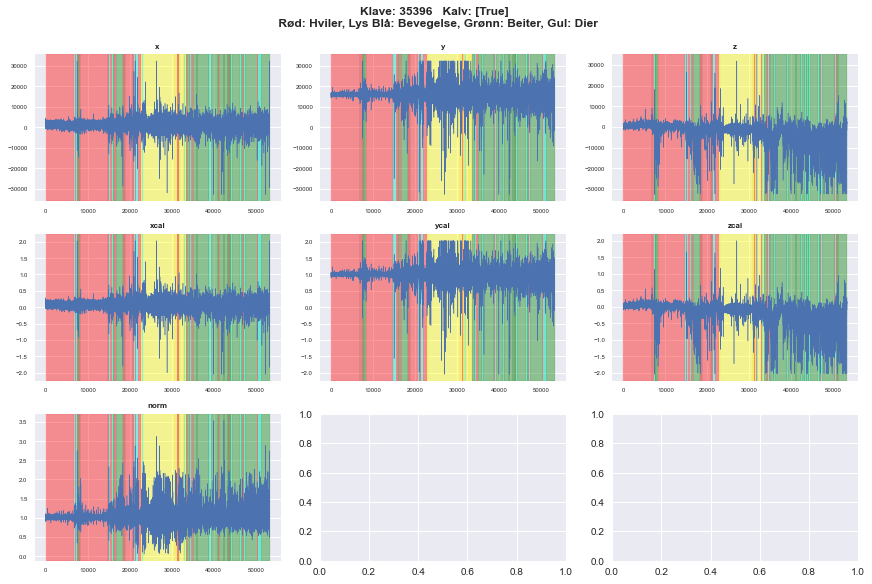

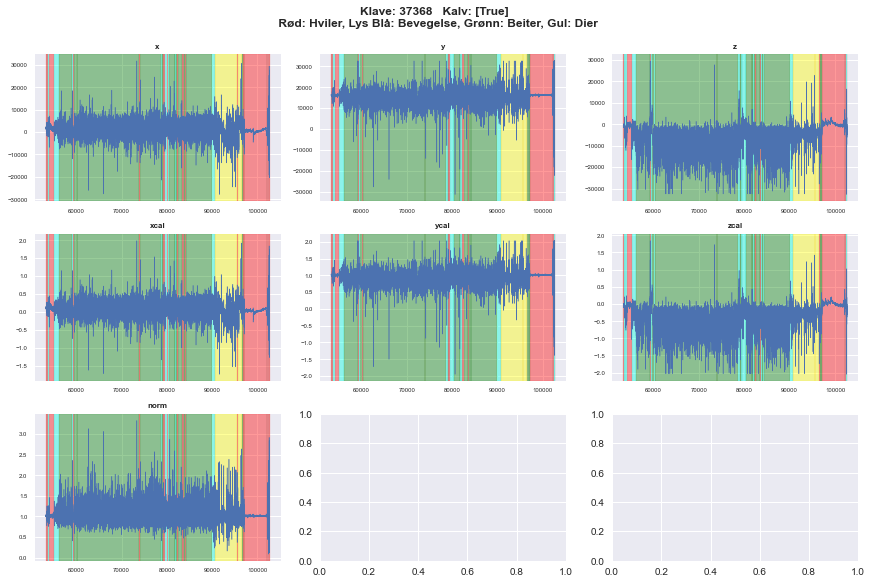

In [23]:
# Visualiser alle klave dataene for klassifiserte perioder
for serial in serials:
    data = select_serial(aks_akt, serial)
    i_interval = create_interval(data)
    
    fig, axes = plt.subplots(nrows=3, ncols=3, constrained_layout=True)
    plt.rcParams.update({'font.size': 10})

    colors = ['red', '#00ffe1', 'green', 'yellow']
    linewidth = 0.5
    figsize = (12, 8)
    plt.suptitle('Klave: {}   Kalv: {} \n Rød: Hviler, Lys Blå: Bevegelse, Grønn: Beiter, Gul: Dier'.format(
        serial,
        data['kalv'].unique()),
        fontweight ="bold")

    i_col = 0
    while i_col < len(columns):
        for row in range(3):
            for col in range(3):
                try:
                    data[columns[i_col]].plot(ax=axes[row,col], linewidth=linewidth, figsize=figsize)
                    axes[row, col].set_title(columns[i_col], fontweight="bold", size=8)
                    axes[row, col].tick_params(labelsize=6)
                except IndexError:
                    break
            
                for interval in i_interval:
                    axes[row,col].axvspan(interval[1], interval[2],
                                          color=colors[interval[0]],
                                          alpha=0.4)
                
                i_col += 1

    fig.show()

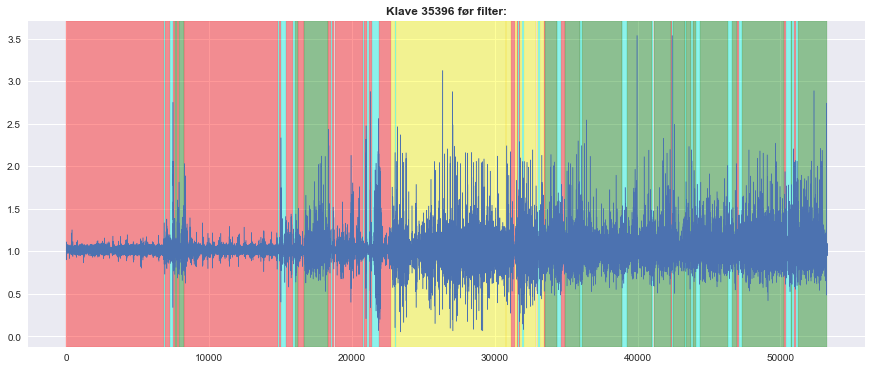

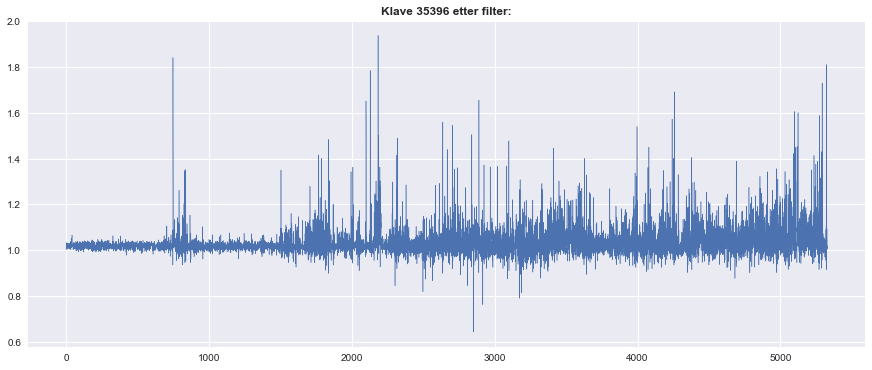

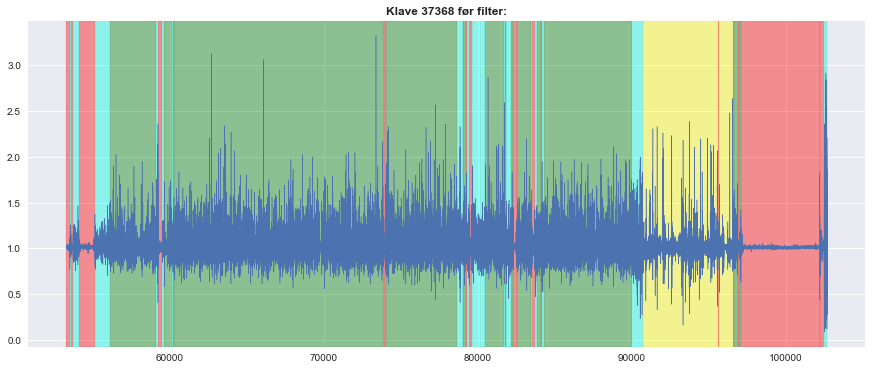

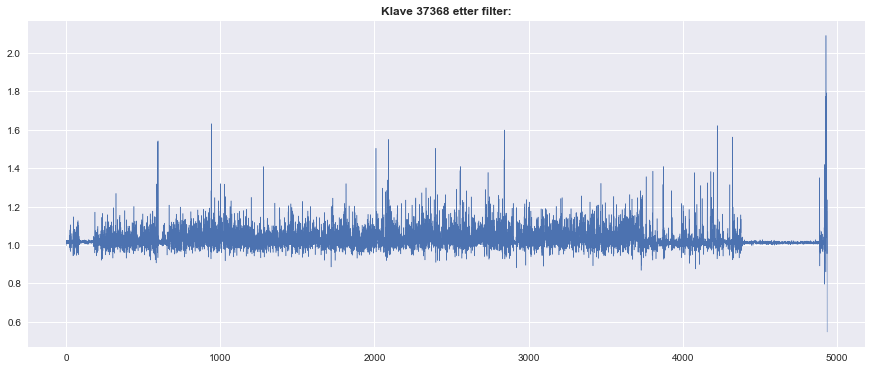

In [24]:
# Større bilde av valgt attributt med støyfiltrering for hver klave
attribute = 'norm'  # Velger ut en attributt
fs = 10 # Sampling frekvens
fc = 1  # Cut-off frekvens på filter
order = 4 # "The order of the filter."
f_type = 'lowpass'

for serial in serials:
    data = select_serial(aks_akt, serial)
    i_interval = create_interval(data)
    data = data[attribute]
    
    # Generere tidsvektor
    t = np.arange(len(data)) / fs

    w = fc / (fs / 2) # Normalisere frekvensen
    b, a = signal.butter(order, w, f_type)
    output = signal.filtfilt(b, a, data)

    plt.figure(figsize=(15, 6))
    plt.plot(data, linewidth=0.5)
    for interval in i_interval:
        plt.axvspan(interval[1], interval[2],
        color=colors[interval[0]],
        alpha=0.4)

    plt.title('Klave {} før filter:'.format(serial), fontweight="bold", size=12)
    plt.tick_params(labelsize=10)
    plt.show()

    plt.figure(figsize=(15, 6))
    plt.plot(t, output, linewidth=0.5, label='filtered')
    plt.title('Klave {} etter filter:'.format(serial), fontweight="bold", size=12)
    plt.tick_params(labelsize=10)
    plt.show()